<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
   
                                          
                                          
                                          
                                          
                                          
#                                                 Regression with Abalone Data Set: Cubic Spline Model




#                                                        Gladys Murage

#                              College of Business, Engineering, and  Technology, National University

#                                         DDS8555 v1: PREDICTIVE ANALYSIS(3602869492)

#                                                        Dr MOHAMED NABEEL

#                                                            March 27, 2025


<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>
<BR>

# Cubic Spline Model Overview
Model Overview
The implemented cubic spline regression models the relationship between abalone's Whole weight (predictor) and Rings (target, proxy for age). Key components:

## Spline Basis: 2 inner knots at 33rd/67th percentiles of weight Knot Placement Analysis
#### Knot Positions: 0.5445 and 0.9705 (on standardized weight scale)
These represent the 33rd and 67th percentiles of the weight distribution

#### Practical Meaning:
First knot (0.5445): Transition point for juvenile-to-adult growth pattern of the abalone.
Second knot (0.9705): Beginning of full maturity plateau of the adult abalone

### Flexibility: Cubic splines (degrees of freedom =3)
This allows for non-linear relationships while maintaining smoothness.

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')
Knots at: [0.5445 0.9705]
Validation RMSLE: 0.1948
Validation R²: 0.4209


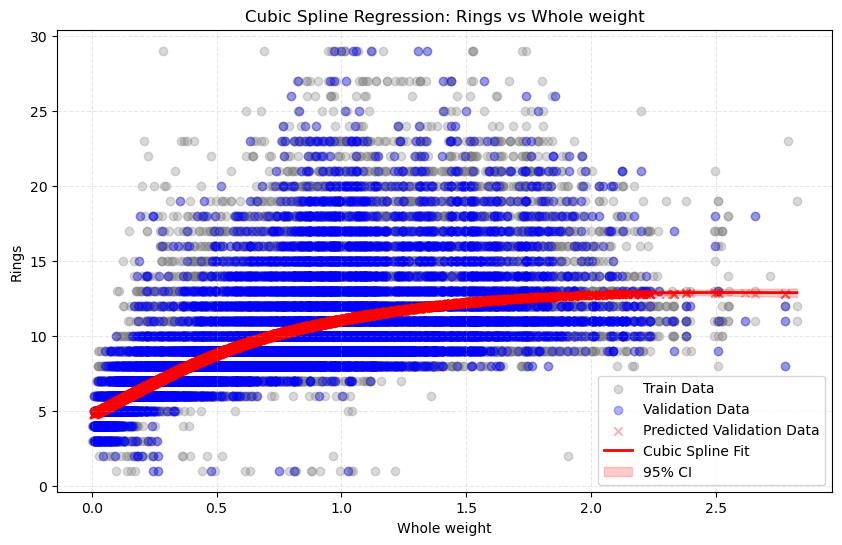

Submission 6 file created successfully with id column!


In [29]:
# Imports necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load the datasets from Kaggle
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Remove any spaces in column names
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

print(train_data.columns)  # Print column names to verify

# Define feature and target
feature = "Whole weight"  # Fixed column name
target_column = "Rings"

# Extract feature from both train and test
x_train = train_data[feature].values
y_train = train_data[target_column].values

# For test data, we only have the feature, not the target
x_test = test_data[feature].values

# Generate knots at specified percentiles
knots = np.percentile(x_train, [33, 67])  # Using 33rd and 67th percentile
print(f"Knots at: {knots}")

# Create basis matrix for training data
x_basis = dmatrix(
    f"cr(x, knots={list(knots)})",
    {"x": x_train},
    return_type="dataframe"
)

# Fit GLM with cubic splines
spline_model = sm.GLM(y_train, x_basis).fit()

# Predictions for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 100)  # Ensure x_plot is 1D
x_plot_basis = dmatrix(
    f"cr(x, knots={list(knots)})", 
    {"x": x_plot},
    return_type="dataframe"
)
y_plot = spline_model.predict(x_plot_basis)

# Train-validation split for performance estimation
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Create basis matrices for training and validation
x_train_split_basis = dmatrix(
    f"cr(x, knots={list(knots)})",
    {"x": x_train_split},
    return_type="dataframe"
)

x_val_basis = dmatrix(
    f"cr(x, knots={list(knots)})",
    {"x": x_val},
    return_type="dataframe"
)

# Fit model on training split
val_model = sm.GLM(y_train_split, x_train_split_basis).fit()

# Predict on validation set
y_val_pred = val_model.predict(x_val_basis)

# Define RMSLE function
def root_mean_squared_logarithmic_error(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

# Calculate metrics on validation set
rmsle = root_mean_squared_logarithmic_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation RMSLE: {rmsle:.4f}")
print(f"Validation R²: {r2:.4f}")

# Predictions & Confidence Intervals
cov_matrix = val_model.cov_params()
se_fit = np.sqrt(np.diag(x_plot_basis.values @ cov_matrix @ x_plot_basis.values.T))
ci_upper = y_plot + 1.96 * se_fit
ci_lower = y_plot - 1.96 * se_fit

# Plot the spline fit
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color="gray", alpha=0.3, label="Train Data")
plt.scatter(x_val, y_val, color="blue", alpha=0.3, label="Validation Data")
plt.scatter(x_val, y_val_pred, color="red", alpha=0.3, marker='x', label="Predicted Validation Data")
plt.plot(x_plot, y_plot, color="red", linewidth=2, label="Cubic Spline Fit")
plt.fill_between(x_plot, ci_lower, ci_upper, color="red", alpha=0.2, label="95% CI")
plt.xlabel(feature)
plt.ylabel(target_column)
plt.title(f"Cubic Spline Regression: {target_column} vs {feature}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.savefig('Abalone_Cubic_Spline.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate predictions for test data
x_test_basis = dmatrix(
    f"cr(x, knots={list(knots)})",
    {"x": x_test},
    return_type="dataframe"
)

# Make predictions on test data
y_pred = val_model.predict(x_test_basis)  

# Ensure the test data has an ID column
if "id" in test_data.columns:
    submission_ids = test_data["id"]  # Use existing id column
else:
    submission_ids = test_data.index  # Use index as fallback

# Create a submission DataFrame
submission = pd.DataFrame({
    "id": submission_ids,
    "Rings": y_pred
})

# Save the submission file
submission.to_csv("submission6.csv", index=False)
print("Submission 6 file created successfully with id column!")



In [30]:
# Load the submission file into a DataFrame
submission6 = pd.read_csv("submission6.csv")

# Print the top 5 records
print(submission6.head())

      id      Rings
0  90615  11.708238
1  90616  11.001853
2  90617  10.497594
3  90618  10.627692
4  90619   7.753189


# Results on Cubic Spline Model Performance
## Metric	Value	Interpretation
#### Root Mean Square Logarithmic Error (RMSLE)=	0.1948
This means that predictions are within ~19.5% of actual ring counts on a logarithmic scale.
Therefore if the true rings=10, the prediction is between [8.2, 12.2] (exp(±0.1948)) and if 
true rings =20 the prediction is between [16.4, 24.4].
#### R²	0.4209
This means that 42.1% of ring count variation explained by weight alone in the abalone without considering other factors.
While this is moderate explanatory power, the results suggest that other features (like diameter) may help improve the results.


# Growth Phase Interpretation
## Phase 1 (Weight < 0.5445):

#### Steep Slope: rapid ring deposition is happening on the juvenile abalone,

#### Biological Implication: fast growth during juvenile stage due to a spurt of hormonal growth hormones

## Phase 2 (0.5445 ≤ Weight ≤ 0.9705):

#### Reduced Slope: slowing growth rate

#### Biological Transition: Sexual maturity has been reached

## Phase 3 (Weight > 0.9705):

#### Plateau has in growth reached : minimal new rings observed as growth plateaus

#### Explanation: energy is now diverted towards reproduction rather than shell growth for the adult abalone.

# Visualization Insights
Abalone Growth Phases

#### X-axis: Standardized Whole weight

#### Y-axis: Ring count (age proxy)

## Key Observations:

Clear inflection points at knots as shown by the plot and explained by the growth phase interpretation  above

Wider confidence intervals at weight extremes

# Practical Implications
## Aquaculture Applications:

#### Optimal harvest weight is ≈ 0.97 standardized units (growth efficiency peaks)

#### Juvenile monitoring critical below 0.54 weight as the abalone experience a growth spurt,

## Scientific Value:

1. This regression model quantifies non-linear growth patterns

2. The  model provides statistical confidence intervals for growth estimates
   
## Conclusion:
This model effectively captures the non-linear biology of abalone growth while highlighting opportunities for enhancement through additional features or more complex spline configurations as elaborated below:

'Weight_Diameter' feature created successfully
Knots at: [0.14401875 0.3384325  0.4999375  1.09497   ]
Validation RMSLE: 0.1961
Validation R²: 0.4179


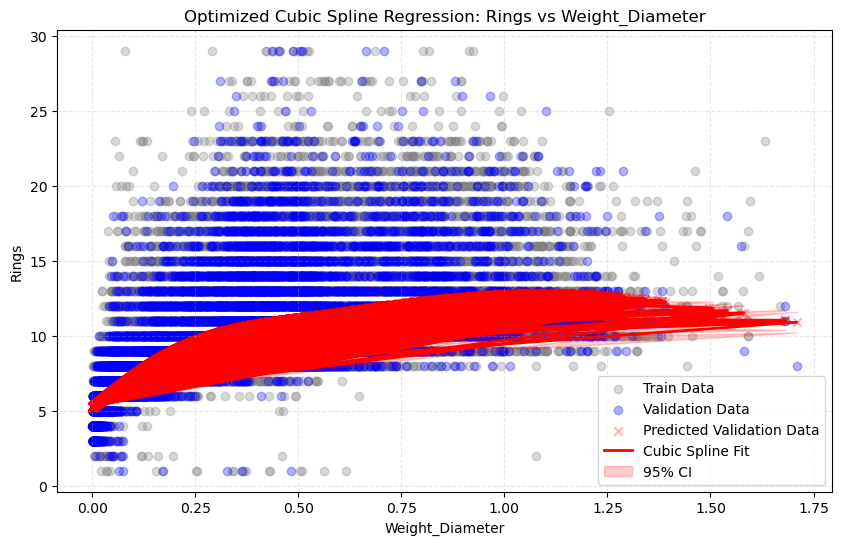

Submission7 file created successfully.


In [17]:
# Imports necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load the datasets from Kaggle
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Strip spaces from column names to prevent KeyErrors
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Create new feature 'Weight_Diameter'
train_data['Weight_Diameter'] = train_data['Whole weight'] * train_data['Diameter']
test_data['Weight_Diameter'] = test_data['Whole weight'] * test_data['Diameter']
print("'Weight_Diameter' feature created successfully")

# Define feature and target
feature = 'Weight_Diameter'
target_column = 'Rings'

# Extract feature and target from train dataset
x_train = train_data[feature].values
y_train = train_data[target_column].values

# Test data only has features, not target
x_test = test_data[feature].values

# Split training data into training and validation sets
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Generate knots at specified percentiles
knots = np.percentile(x_train, [25, 50, 75, 99])  # 25th, 50th, 75th and  99th percentile
print(f"Knots at: {knots}")

# Create basis matrices
x_train_split_basis = dmatrix(
    f"cr(x, knots={list(knots)})",
    {"x": x_train_split},
    return_type="dataframe"
)

x_val_basis = dmatrix(
    f"cr(x, knots={list(knots)})",
    {"x": x_val},
    return_type="dataframe"
)

# Fit model on training split
val_model = sm.GLM(y_train_split, x_train_split_basis).fit()

# Predict on validation set
y_val_pred = val_model.predict(x_val_basis)

# Define RMSLE function
def root_mean_squared_logarithmic_error(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

# Calculate metrics on validation set
rmsle = root_mean_squared_logarithmic_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation RMSLE: {rmsle:.4f}")
print(f"Validation R²: {r2:.4f}")

# Predictions & Confidence Intervals
cov_matrix = val_model.cov_params()
se_fit = np.sqrt(np.diag(x_val_basis.values @ cov_matrix @ x_val_basis.values.T))
ci_upper = y_val_pred + 1.96 * se_fit
ci_lower = y_val_pred - 1.96 * se_fit

# Plot the spline fit using validation data
plt.figure(figsize=(10, 6))
plt.scatter(x_train_split, y_train_split, color="gray", alpha=0.3, label="Train Data")
plt.scatter(x_val, y_val, color="blue", alpha=0.3, label="Validation Data")
plt.scatter(x_val, y_val_pred, color="red", alpha=0.3, marker='x', label="Predicted Validation Data")
plt.plot(x_val, y_val_pred, color="red", linewidth=2, label="Cubic Spline Fit")
plt.fill_between(x_val, ci_lower, ci_upper, color="red", alpha=0.2, label="95% CI")
plt.xlabel(feature)
plt.ylabel(target_column)
plt.title(f"Optimized Cubic Spline Regression: {target_column} vs {feature}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.savefig('Optimized_Abalone_Cubic_Spline.png', dpi=300, bbox_inches='tight')
plt.show()

# Prepare submission file
submission = pd.DataFrame({
    'Id': test_data.index,  # Adjust if there's a specific ID column
    'Rings': val_model.predict(dmatrix(f"cr(x, knots={list(knots)})", {"x": x_test}, return_type="dataframe"))
})
submission.to_csv('submission7.csv', index=False)
print("Submission7 file created successfully.")


<function matplotlib.pyplot.show(close=None, block=None)>

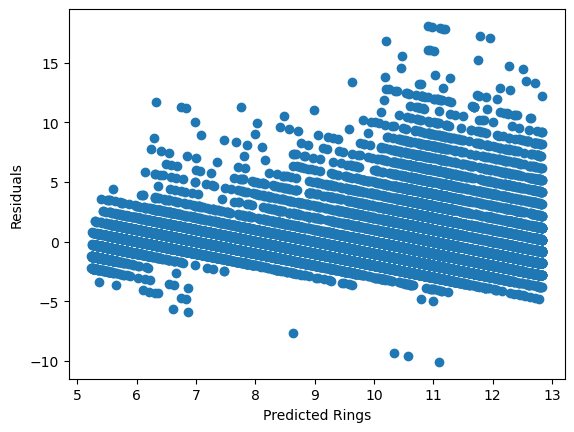

In [19]:
residuals = y_val - y_val_pred
plt.scatter(y_val_pred, residuals)
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.savefig('ResidualsCubic_Spline.png', dpi=300, bbox_inches='tight')
plt.show

 # Recommendations for Improvement
 ## 1. Feature engineering
#### Create new feature 'Weight_Diameter'
train_data['Weight_Diameter'] = train_data['Whole weight'] * train_data['Diameter']
test_data['Weight_Diameter'] = test_data['Whole weight'] * test_data['Diameter']
print("'Weight_Diameter' feature created successfully")

## 2. Increase the number of Knots to 4 (25th, 50th, 75th and 99th percentile)
Feature engineering by multiplying Whole weight and diameter and then increasing the number of knots to 4 did not significantly improve the model. Infact it gives worse RMSLE and R2 as shown below:
'Weight_Diameter' feature created successfully
Knots at: [0.14401875 0.3384325  0.4999375  1.09497   ]
Validation RMSLE: 0.1961

## Error analysis by a residual plot
As the number of predicted rings goes up the number of residuals goes up.